# Fitting resonators with GARFIELD for coupler

In [3]:
import os, sys
from functools import partial
import numpy as np
from scipy.constants import c
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../garfield/')
from Genetic_algorithm import *
from Minimization_functions import *
from Resonator_formula import *
from framework import GeneticAlgorithm
from scipy.signal import find_peaks

#%matplotlib ipympl

In [4]:
# Importing impedance data
data_impedance = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/COUPLER/5FerritesCoupler.txt', comments='#', delimiter='\t')

# Frequency

freq_data = data_impedance[:,0]*1e9

# Impedance

imp_data = np.abs(data_impedance[:,1] + 1j*data_impedance[:,2])

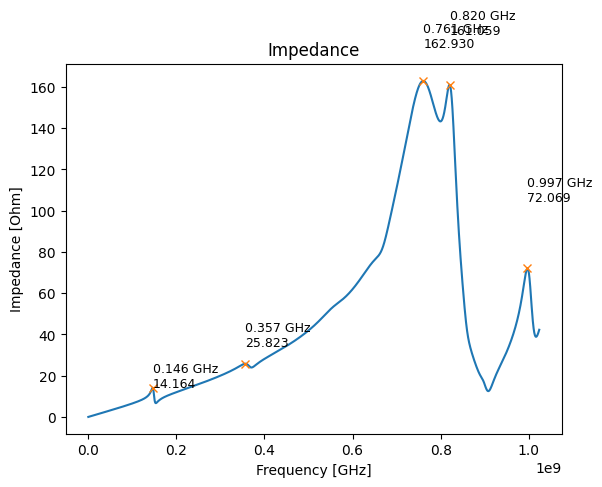

array([14270, 34837, 74283, 80103, 97393])

In [5]:
plt.figure()

peaks, peaks_height = find_peaks((imp_data), height=2, threshold=None)
for i, (peak, height) in enumerate(zip(peaks, peaks_height['peak_heights'])):
    plt.text(freq_data[peak], imp_data[peak] + (i * 0.05 * max(imp_data)), f'{freq_data[peak]/1e9:.3f} GHz\n{height:.3f}', fontsize=9)

plt.plot(freq_data, (imp_data))
plt.plot(freq_data[peaks], (imp_data[peaks]), "x")
plt.xlabel('Frequency [GHz]')
plt.ylabel('Impedance [Ohm]')
plt.title('Impedance')


plt.show()

peaks

In [16]:
#Number of resonators
Nres = 7 # can be changed to see what happens

#wake_length = 100 # simulated wake length in [m], can be 10,200, 1000, 2000, 4000
frequency_data = freq_data #frequencies in Hz
impedance_data = np.array(data_impedance[:,1] + \
                          1j*data_impedance[:,2])

time_data = np.zeros(1)
wake_data = np.zeros(1)
#supply the wake length to the resonator formula to use the 
#partially decayed wake variant 

n_Resonator_longitudinal_imp = partial(n_Resonator_longitudinal_imp)

parameterBounds = [(1, 200), (1,50), (0.145e9, 0.152e9),
                    (1, 200), (1,50), (0.355e9, 0.375e9),
                    (1, 200), (1,50), (0.65e9, 0.67e9),
                    (10, 200), (5,50), (0.765e9, 0.777e9),
                    (10, 200), (5,50), (0.816e9, 0.8175e9),
                    (1, 200), (1,50), (0.86e9, 0.9e9),
                    (10, 200), (5,50), (0.99, 1.01e9)]
 # Bounds: [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].

### Running the GA

In [17]:
%%time
GA_model_scipy_1 = GeneticAlgorithm(frequency_data, 
                                  impedance_data, 
                                  time_data, 
                                  wake_data, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredErrorReal, #sumOfSquaredErrorReal else...
                                  fitFunction=n_Resonator_longitudinal_imp,
                                 )

GA_model_scipy_1.run_geneticAlgorithm(maxiter=30000, 
                                    popsize=25, 
                                    tol=0.001, 
                                    mutation=(0.3, 0.8),
                                    crossover_rate=0.5
                                   )
print(GA_model_scipy_1.warning)

Progress: [####################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.84e+00        |      24.05       |    1.485e+08     
    2     |        3.82e+00        |      29.22       |    3.638e+08     
    3     |        6.95e+00        |       4.47       |    6.501e+08     
    4     |        1.45e+02        |       9.89       |    7.688e+08     
    5     |        1.01e+02        |      29.31       |    8.161e+08     
    6     |        1.02e+00        |      49.31       |    8.945e+08     
    7     |        4.79e+01        |      36.32       |    1.001e+09     
----------------------------------------------------------------------
Optimization terminated successfully.
CPU times: user 2min 38s, sys: 1min 15s, total: 3min 53s
Wall time: 33min 30s


In [18]:
%%time
GA_model_scipy_1.run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.34e+00        |      19.47       |    1.483e+08     
    2     |        2.95e+00        |      20.85       |    3.617e+08     
    3     |        7.03e+00        |       5.73       |    6.267e+08     
    4     |        1.46e+02        |       9.71       |    7.687e+08     
    5     |        9.97e+01        |      29.49       |    8.161e+08     
    6     |        1.53e+00        |      40.05       |    9.618e+08     
    7     |        4.82e+01        |      37.49       |    1.002e+09     
----------------------------------------------------------------------
CPU times: user 53.7 s, sys: 41.4 ms, total: 53.8 s
Wall time: 53.9 s


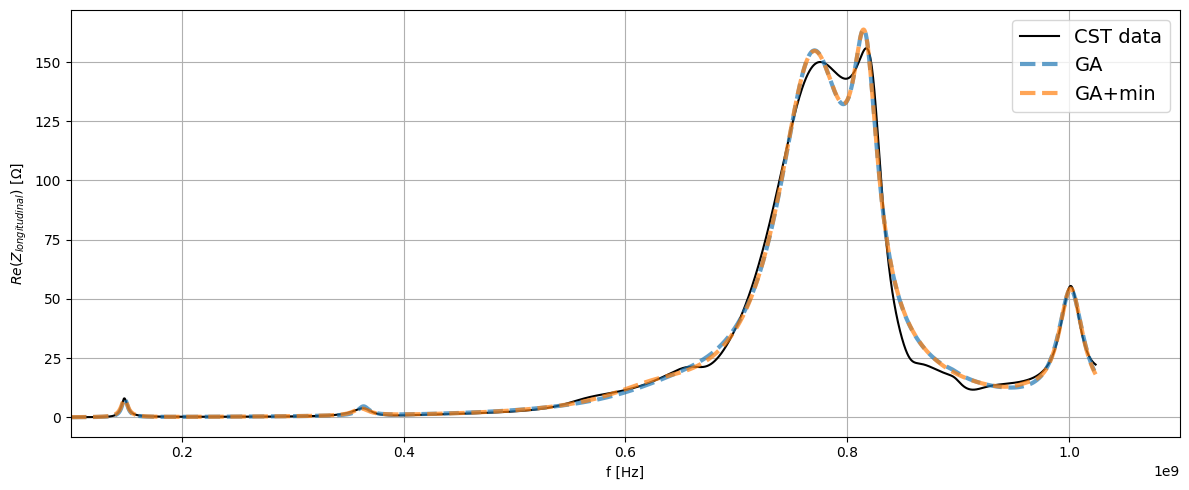

In [19]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.fitFunction(GA_model_scipy_1.frequency_data, dict(enumerate(GA_model_scipy_1.geneticParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='GA', alpha=0.7)

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.fitFunction(GA_model_scipy_1.frequency_data, dict(enumerate(GA_model_scipy_1.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='GA+min', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()

In [21]:
GA_model_scipy_1.minimizationParameters.reshape(-1, 3)

array([[7.34209256e+00, 1.94703224e+01, 1.48275154e+08],
       [2.95406143e+00, 2.08494475e+01, 3.61650844e+08],
       [7.02622001e+00, 5.72598780e+00, 6.26657867e+08],
       [1.45846879e+02, 9.70734310e+00, 7.68746136e+08],
       [9.97144657e+01, 2.94894591e+01, 8.16132799e+08],
       [1.53153725e+00, 4.00536176e+01, 9.61809941e+08],
       [4.81657449e+01, 3.74871236e+01, 1.00156559e+09]])

In [10]:
#Number of resonators
Nres = 2 # can be changed to see what happens

#wake_length = 100 # simulated wake length in [m], can be 10,200, 1000, 2000, 4000
frequency_data = data_impedance[:int(len(data_impedance)*0.4),0]*1e9 #frequencies in Hz
impedance_data = data_impedance[:int(len(data_impedance)*0.4),1] + 1j*data_impedance[:int(len(data_impedance)*0.4),2]

time_data = np.zeros(1)
wake_data = np.zeros(1)
#supply the wake length to the resonator formula to use the 
#partially decayed wake variant 

wake_length = 1000
n_Resonator_longitudinal_imp = partial(n_Resonator_longitudinal_imp)#, wake_length=wake_length)

parameterBounds = [(1, 200), (1,50), (0.145e9, 0.152e9),
                    (1, 200), (1,50), (0.355e9, 0.375e9)]
 # Bounds: [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].

In [11]:
%%time
GA_model_scipy_2 = GeneticAlgorithm(frequency_data, 
                                  impedance_data, 
                                  time_data, 
                                  wake_data, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredErrorReal,
                                  fitFunction=n_Resonator_longitudinal_imp,
                                 )

GA_model_scipy_2.run_geneticAlgorithm(maxiter=30000, 
                                    popsize=25, 
                                    tol=0.001, 
                                    mutation=(0.3, 0.8),
                                    crossover_rate=0.5
                                   )
print(GA_model_scipy_2.warning)

Progress: [######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.89e+00        |      21.04       |    1.483e+08     
    2     |        3.52e+00        |      11.96       |    3.619e+08     
----------------------------------------------------------------------
Optimization terminated successfully.
CPU times: user 6.69 s, sys: 2.16 s, total: 8.85 s
Wall time: 11.3 s


In [12]:
%%time
GA_model_scipy_2.run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.88e+00        |      20.96       |    1.483e+08     
    2     |        3.51e+00        |      11.95       |    3.619e+08     
----------------------------------------------------------------------
CPU times: user 440 ms, sys: 1.12 ms, total: 441 ms
Wall time: 442 ms


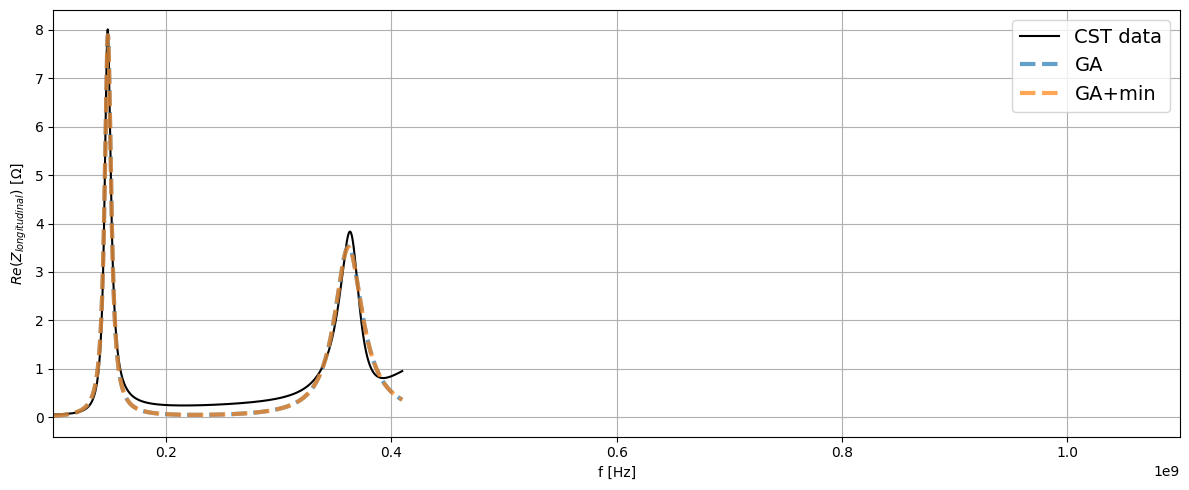

In [13]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy_2.frequency_data, GA_model_scipy_2.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy_2.frequency_data, GA_model_scipy_2.fitFunction(GA_model_scipy_2.frequency_data, dict(enumerate(GA_model_scipy_2.geneticParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='GA', alpha=0.7)

ax0.plot(GA_model_scipy_2.frequency_data, GA_model_scipy_2.fitFunction(GA_model_scipy_2.frequency_data, dict(enumerate(GA_model_scipy_2.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='GA+min', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()

[[7.87968931e+00 2.09615813e+01 1.48301549e+08]
 [3.50721497e+00 1.19450602e+01 3.61874679e+08]
 [7.04935355e+00 4.41966439e+00 6.50030678e+08]
 [1.45271612e+02 9.90617573e+00 7.69062243e+08]
 [1.00486531e+02 2.95277966e+01 8.16083825e+08]
 [1.03127378e+00 4.94984627e+01 8.95809040e+08]
 [4.79116184e+01 3.60929606e+01 1.00145026e+09]]


/home/malthera/miniconda3/envs/garfield-env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/malthera/miniconda3/envs/garfield-env/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


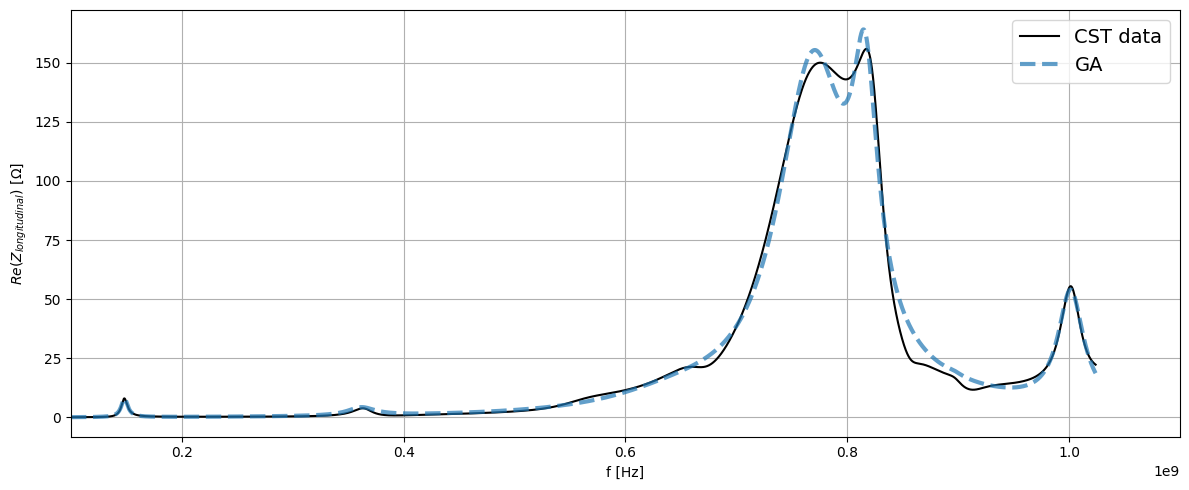

In [ ]:
sumofGA = np.concatenate((GA_model_scipy_2.minimizationParameters.reshape(-1, 3), GA_model_scipy_1.minimizationParameters.reshape(-1, 3)), axis=0)

print(sumofGA)

#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.fitFunction(GA_model_scipy_1.frequency_data, dict(enumerate(sumofGA))),
         lw = 3, linestyle='--', label='GA', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()